In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import netCDF4

In [3]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 512 if AVAIL_GPUS else 64

In [4]:
pl.seed_everything(125)

Global seed set to 125


125

## Load Data

In [5]:
sho = netCDF4.Dataset('../data/sho.nc').variables
t_sho = np.array(sho['t'][:], dtype=np.float32)
s_sho = np.array(sho['s'][:], dtype=np.float32)
v_sho = np.array(sho['v'][:], dtype=np.float32)

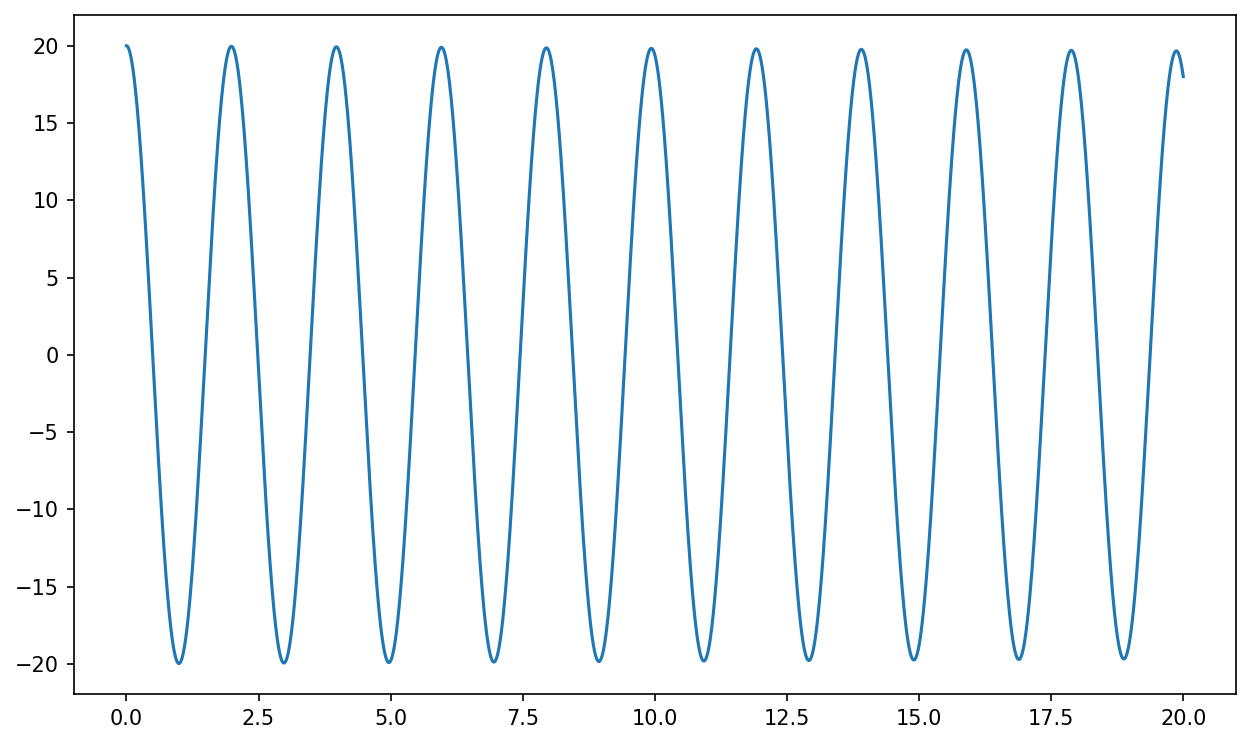

In [6]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, s_sho)
plt.show()

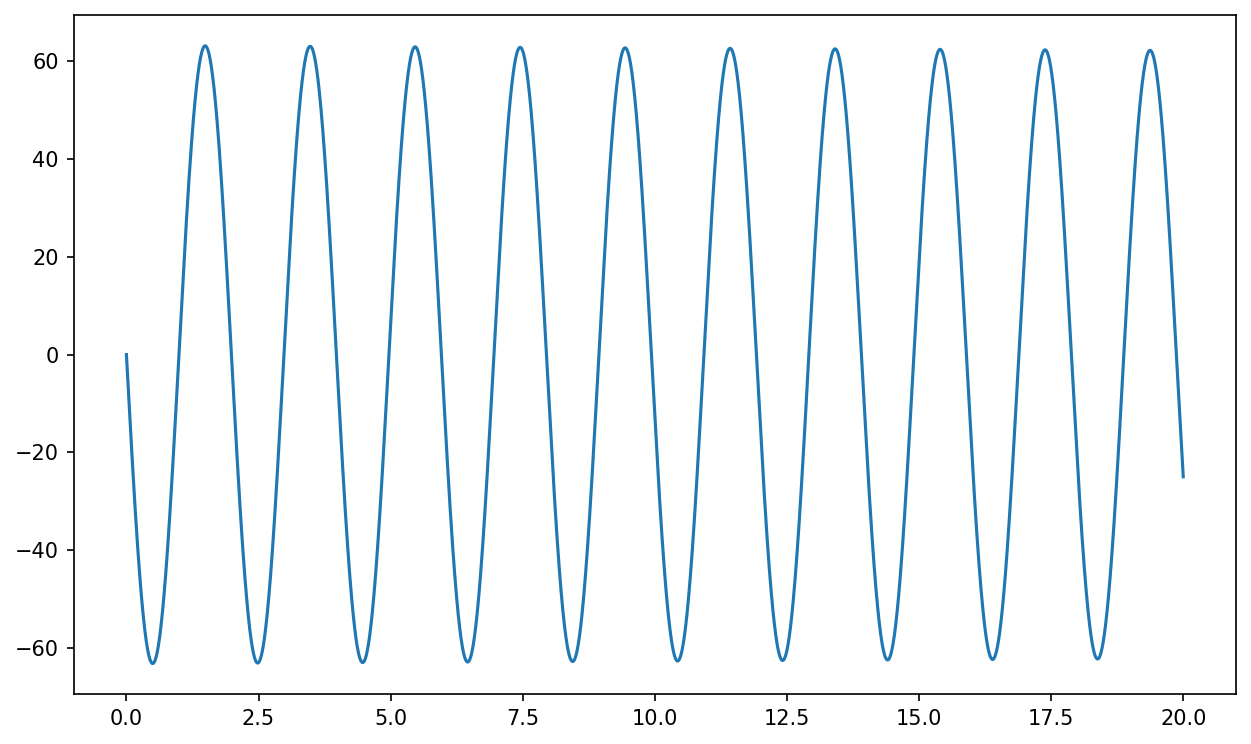

In [7]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, v_sho)
plt.show()

In [8]:
# X_total = np.column_stack([s_sho, v_sho])
X_total = s_sho.reshape(-1, 1)
sc = MinMaxScaler()
X_normalized = sc.fit_transform(X_total)

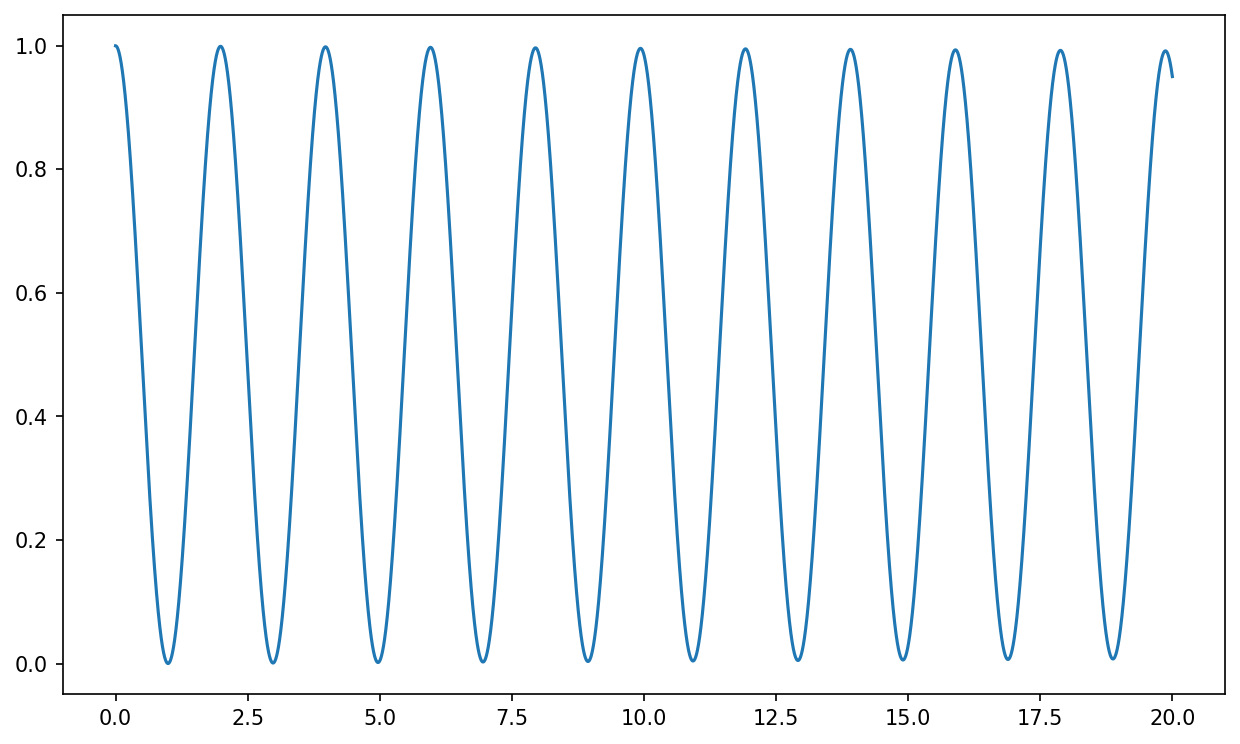

In [9]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, X_normalized[:,0])
plt.show()

In [10]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-3):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+2]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [11]:
X, y = sliding_window(X_normalized, 10)

In [12]:
X.shape

(19988, 10, 1)

In [13]:
y.shape

(19988, 2, 1)

In [14]:
N = X.shape[0]
N_train = 14000
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:19000]
y_test = y[N_train:19000]

In [15]:
class NewtonData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
ds_train = NewtonData(X_train, y_train)
ds_val = NewtonData(X_test, y_test)

In [17]:
len(ds_train)

14000

In [18]:
len(ds_val)

5000

In [19]:
ds_train[0][0].shape

(10, 1)

In [20]:
dl_train = DataLoader(ds_train, batch_size=100)

In [21]:
ds_train[0]

(array([[1.        ],
        [0.9999971 ],
        [0.99998915],
        [0.9999763 ],
        [0.99995834],
        [0.9999354 ],
        [0.99990743],
        [0.99987453],
        [0.9998366 ],
        [0.9997937 ]], dtype=float32),
 array([[0.9997457 ],
        [0.99969286]], dtype=float32))

In [22]:
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, 1, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, 2)
        
    def forward(self, x):
        # input shape: batch, seq, dim
        rnn_output, _ = self.rnn(x)
        output = self.fc(rnn_output)
        
        return output[:,-1,:]

In [23]:
model = SingleRNN(input_size=1, hidden_size=100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
model.eval()
dl_iter = iter(dl_train)
x_one, y_one = next(dl_iter)

In [25]:
x_one.shape

torch.Size([100, 10, 1])

In [26]:
y_one.shape

torch.Size([100, 2, 1])

In [27]:
model(x_one).shape

torch.Size([100, 2])

In [29]:
epochs = 100
model.train()
for epoch in range(epochs+1):
    for x, y in dl_train:
        y_hat = model(x)
        optimizer.zero_grad()
        loss = criterion(y_hat, y.view(-1, 2))
        loss.backward()
        optimizer.step()
        
    if epoch%10==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.00246376
epoch:   10 loss:0.00001683
epoch:   20 loss:0.00001941
epoch:   30 loss:0.00002976
epoch:   40 loss:0.00002886
epoch:   50 loss:0.00002274
epoch:   60 loss:0.00001510
epoch:   70 loss:0.00001357
epoch:   80 loss:0.00002381
epoch:   90 loss:0.00001504
epoch:  100 loss:0.00002947


In [34]:
model.eval()

SingleRNN(
  (rnn): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [35]:
X, y = sliding_window(X_normalized, 10)

In [36]:
total_data = NewtonData(X, y)

In [37]:
dl = DataLoader(total_data, batch_size=len(total_data))
dl_iter = iter(dl)
X, y = next(dl_iter)

In [38]:
y.shape

torch.Size([19988, 2, 1])

In [39]:
t = t_sho[10:-3]
t.shape

(19988,)

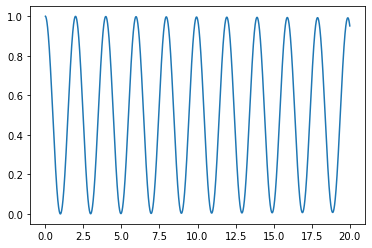

In [37]:
plt.plot(t, y.cpu().numpy())

In [38]:
y_pred = model(X)

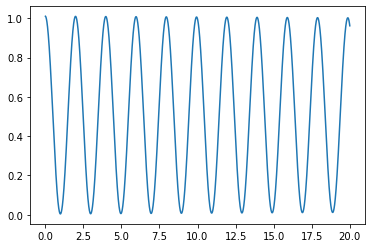

In [39]:
plt.plot(t, y_pred.detach().numpy())

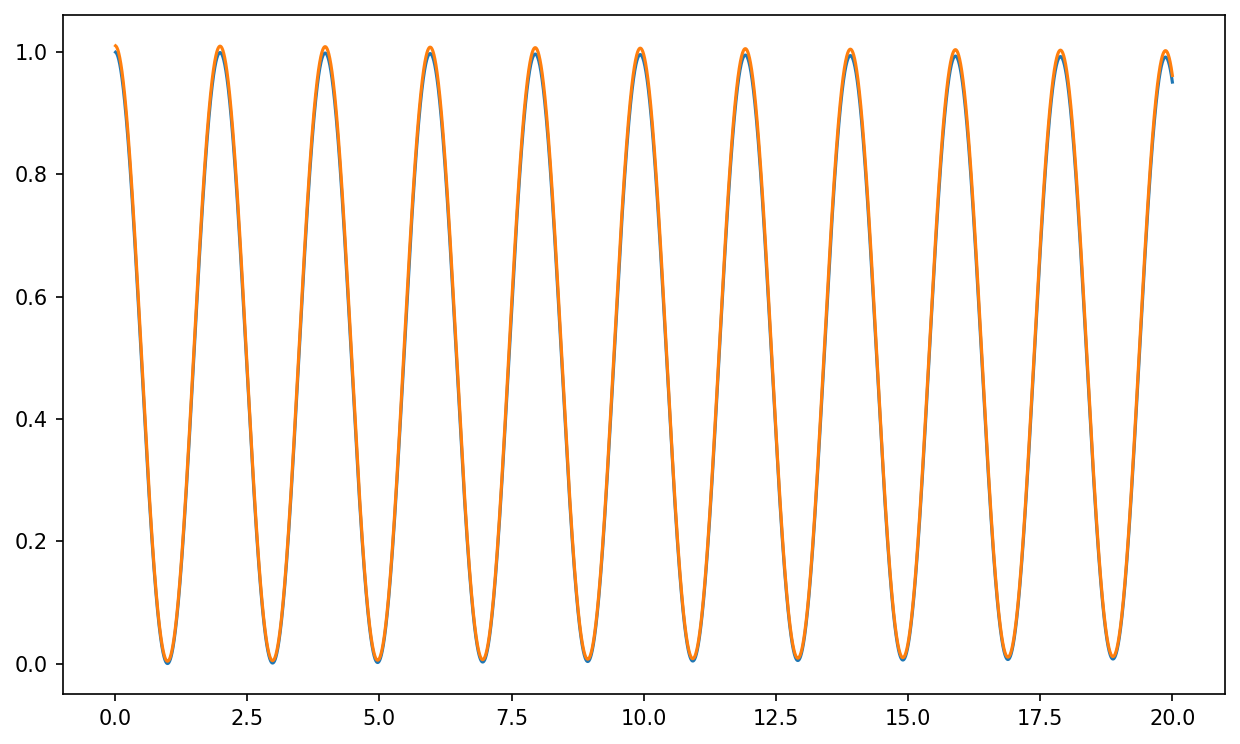

In [40]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t, y.cpu().numpy())
plt.plot(t, y_pred.detach().numpy())
plt.show()

In [41]:
N_extrap = 100
X_new = X[-1]
X_new.shape

torch.Size([10, 1])

In [42]:
X_new.view(1,-1,1)

tensor([[[0.9568],
         [0.9563],
         [0.9557],
         [0.9551],
         [0.9545],
         [0.9539],
         [0.9533],
         [0.9527],
         [0.9521],
         [0.9515]]])

In [43]:
y_ex = []
t_ex = []
dt = 1e-3
for i in range(N_extrap):
    y_new = model(X_new.view(1, -1, 1))
    X_new = torch.concat([X_new[1:], y_new])
    t_ex.append(t_sho[-1] + i * dt)
    y_ex.append(y_new.view(-1).detach().numpy())

In [44]:
t_total = np.concatenate([t, t_ex])
y_pred_total = np.concatenate([y_pred.detach().numpy(), y_ex])

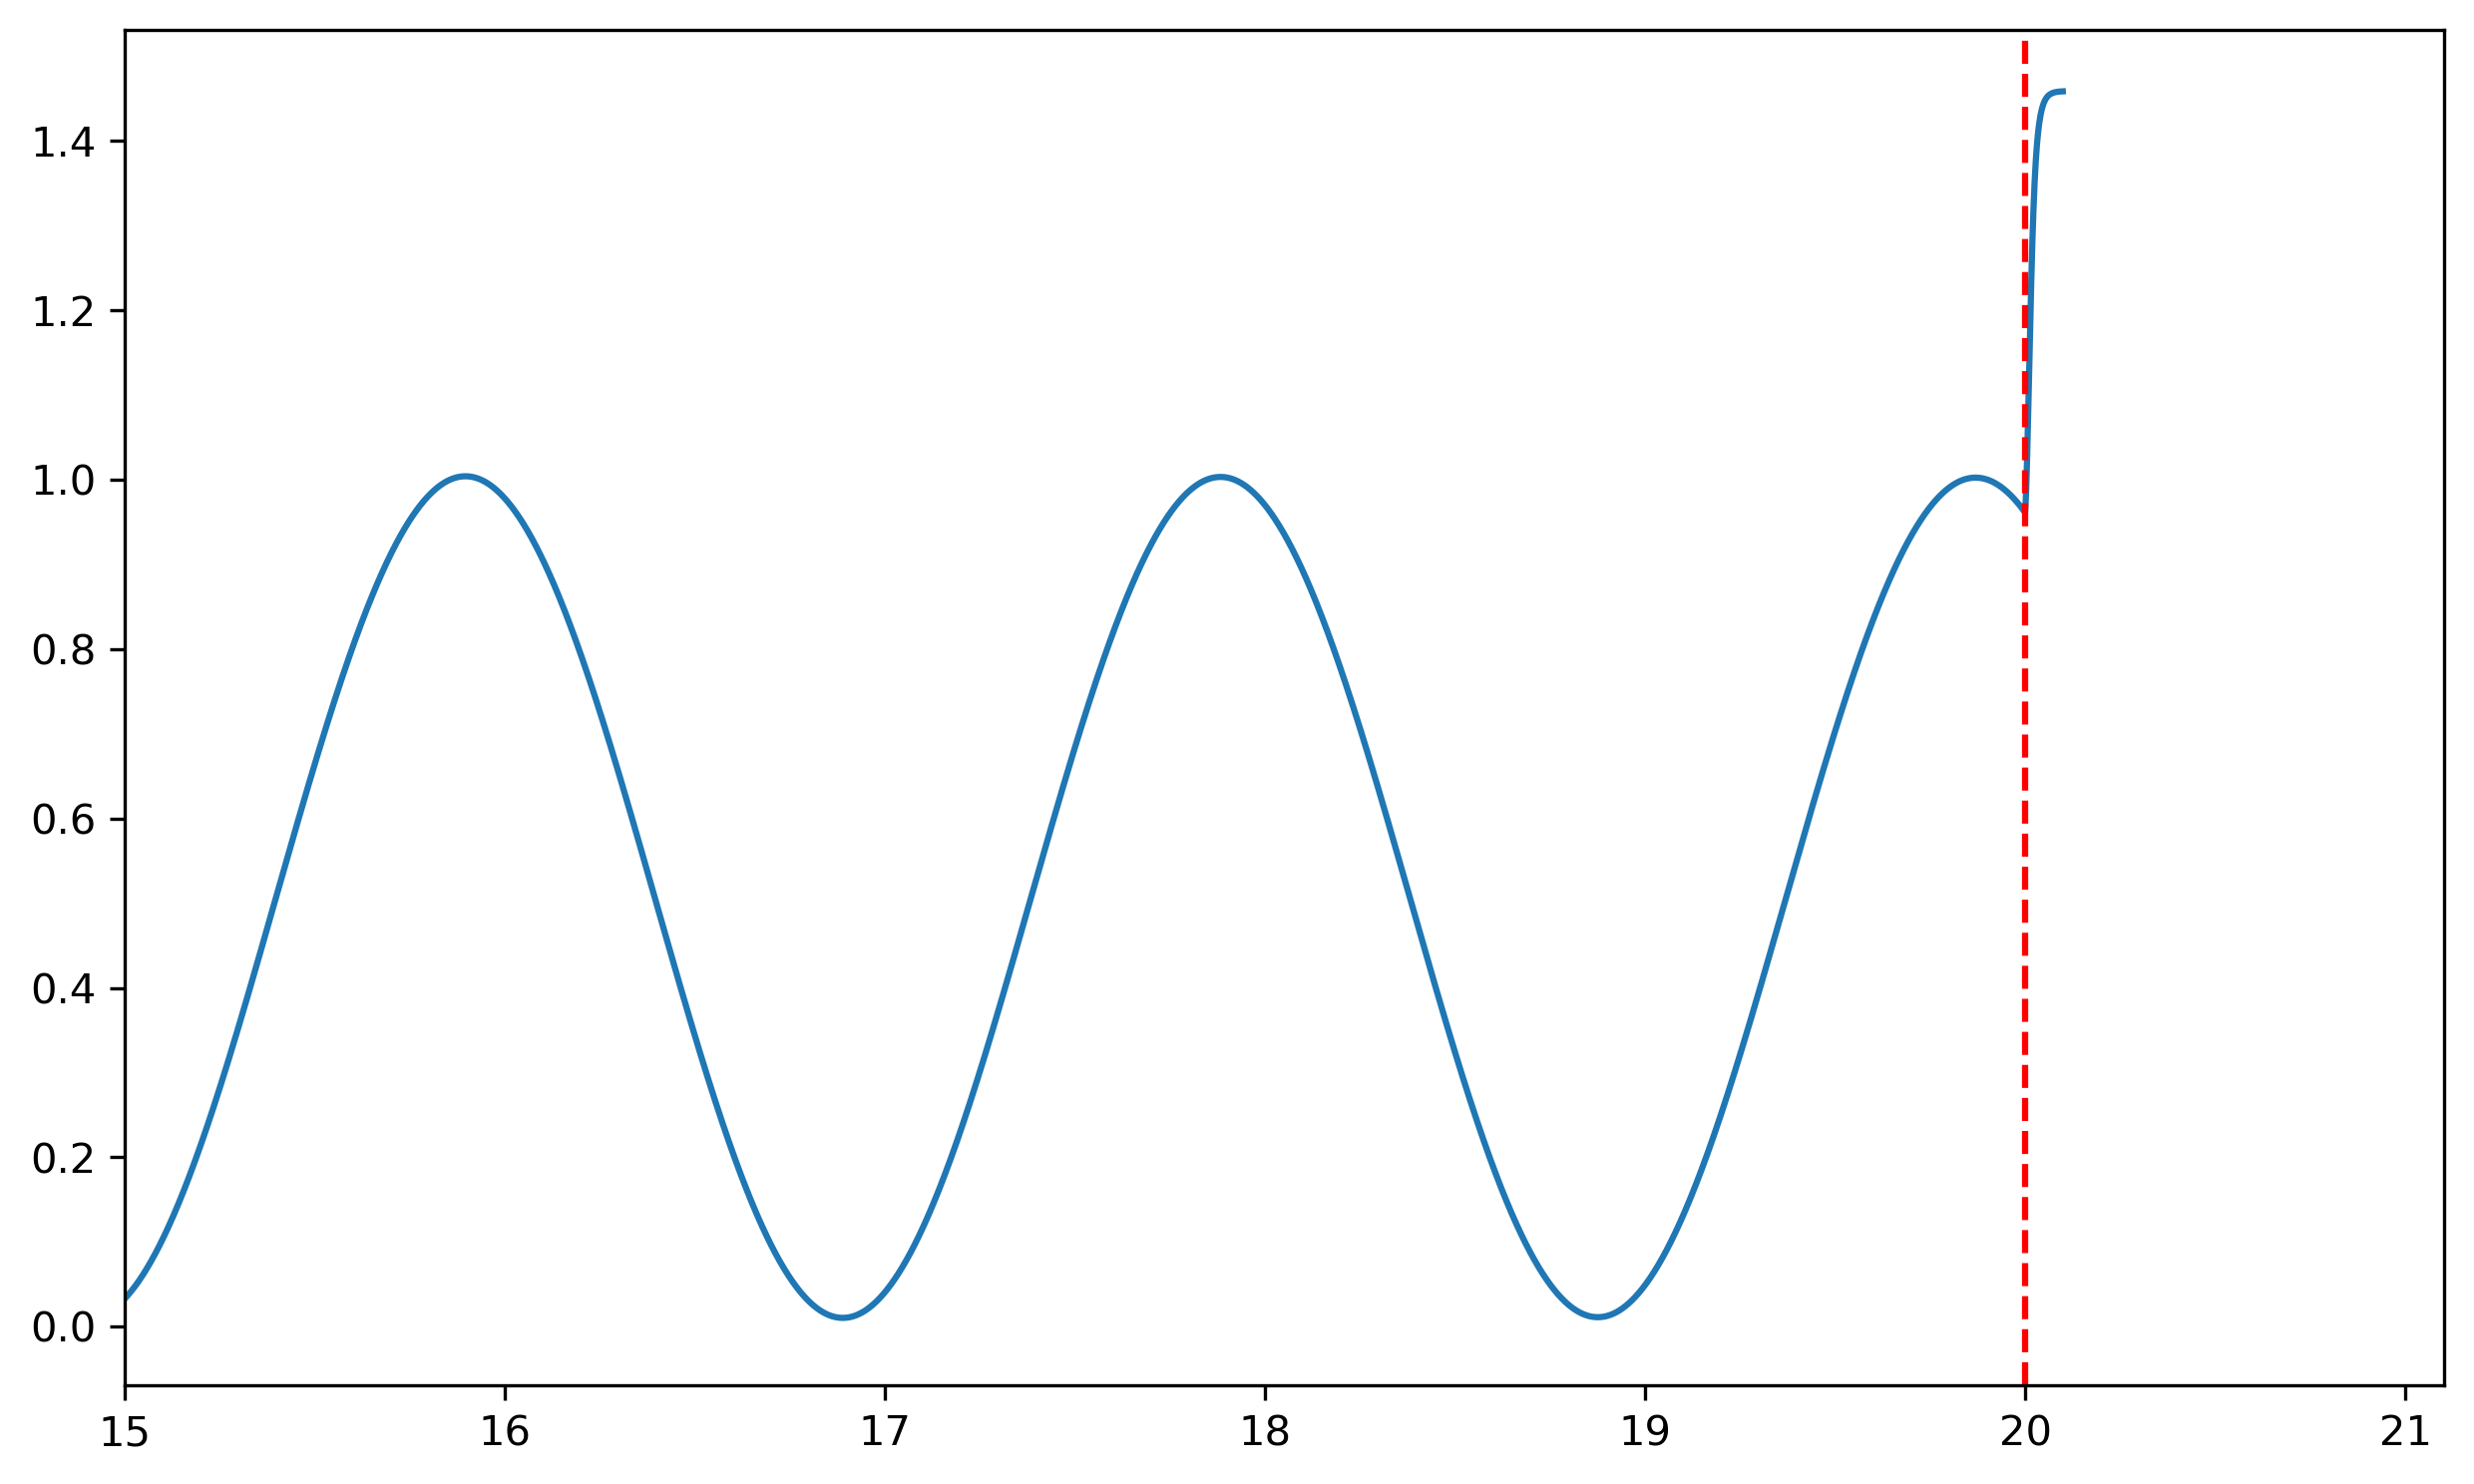

In [45]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t_total, y_pred_total)
plt.xlim(left=15)
plt.axvline(t[-1], linestyle='--', color='r')